# FinBert
`Env: python 3.11.5 (conda sentiment)`\
`transformer: pip install transformers[sentencepiece]`

In [1]:
%load_ext autoreload
%autoreload 2'
import matplotlib.pyplot as plt
import torch, gc, sys
import pandas as pd
import numpy as np
import transformers
import datetime
import warnings
import json
from scipy.stats.mstats import winsorize
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AdamW,\
    get_linear_schedule_with_warmup, BertConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.nn.functional import softmax
warnings.filterwarnings("ignore")
transformers.__version__

"""
from google.colab import drive
drive.mount('/content/drive')
!pip install googletrans
"""

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

## 1. Data

### Data Preprocess

In [3]:
from utils import *
"""
from utils import get_cpu_usage, get_ram_usage, trans
from utils import prc_data
from utils import get_text_data
from utils import text_concatenate_diff_data
from utils import text_concatenate_diff_data
from utils import merge_prc_text, text_concatenate_within_same_date, process_time
"""

'\nfrom utils import get_cpu_usage, get_ram_usage, trans\nfrom utils import prc_data\nfrom utils import get_text_data\nfrom utils import text_concatenate_diff_data\nfrom utils import text_concatenate_diff_data\nfrom utils import merge_prc_text, text_concatenate_within_same_date, process_time\n'

In [4]:
# texts data: 2409 => anue_2409_20231208to20211224
# texts data: 友達 => anue_友達_20231215to20221227
# texts data: 面板 => anue_面板_20231216to20230412
data_1 = get_text_data("anue_2409_20231208to20211224")
data_2 = get_text_data("anue_友達_20231215to20221227")
data_3 = get_text_data("anue_面板_20231216to20230412")

# to dict
data_1 = data_1.set_index(["time"])["content"].to_dict()
data_2 = data_2.set_index(["time"])["content"].to_dict()
data_3 = data_3.set_index(["time"])["content"].to_dict()

stock = "2409.TW"
list_of_data = [data_2, data_3]
data = text_concatenate_diff_data(list_of_data)
prc = prc_data(stock)
data = process_time(prc, data)
data = text_concatenate_within_same_date(data)
prc_text = merge_prc_text(prc, data).rename(columns={'content': 'stock'})
prc_text.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
duplicated time: 0


### Translate data

In [ ]:
"""
In pretrained model, decide the scores for each articles and add the scores together
for those in the same date. In finetuning, since we are going to get the sum of the 
influence of each artclie for a single day, we do not regard the unit as article but
all articles in the same day.
"""
import pickle
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
texts_name = 'stock'
len_tokens = []
not_work_time = []
trans_ret_data = {}


for index, (time, returns, content) in prc_text[["time", "return", texts_name]].iterrows():
    try:
        trans_content = trans([content])
        trans_ret_data[time] = [returns, trans_content]
    except:
        print('error')
        print(content)
        not_work_time.append(time)


with open("_temp/trans_data.pk", "wb") as f:
    pickle.dump(trans_ret_data, f)
not_work_time

In [ ]:
# Load translated data
with open("_temp/trans_data.pk", "rb") as f:
    trans_ret_data = pickle.load(f)

trans_ret_data= pd.DataFrame(trans_ret_data).transpose().reset_index()
trans_ret_data.columns = ['time', 'returns', 'trans']
trans_ret_data.set_index('time', inplace=True)
trans_ret_data

"""
COLAB
with open("/content/drive/MyDrive/sentiment/_temp/trans_data.pk", "rb") as f:
    trans_ret_data = pickle.load(f)
"""

### Split data

In [ ]:
trans_ret_data.reset_index(inplace=True)
time_val = datetime.datetime(2023, 8, 1).date()
time_test = datetime.datetime(2023, 9, 1).date()
data_train = trans_ret_data[trans_ret_data["time"] <= time_val]
data_val = trans_ret_data[(trans_ret_data["time"] >= time_val) & (trans_ret_data["time"] <= time_test)]
data_test = trans_ret_data[trans_ret_data["time"] >= time_test]

### Tokenising

In [ ]:
def tokenising(data):
    # tokens data
    trans_content = [i[0] for i in list(data['trans'])]
    inputs = tokenizer(trans_content, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    token_type_ids = inputs["token_type_ids"]
    attention_mask = inputs["attention_mask"]

    # returns data
    returns = torch.tensor(data.reset_index()["returns"])
    return (input_ids, token_type_ids, attention_mask, returns)

data_train_tokenised = tokenising(data_train)
data_val_tokenised = tokenising(data_val)
data_test_tokenised = tokenising(data_test)

### Dataloader

In [ ]:
batch_size = 1
def get_loader(data_tokenised, batch_size):
    (input_ids, token_type_ids, attention_mask, returns) = data_tokenised
    dataset = TensorDataset(input_ids, token_type_ids, attention_mask, returns)
    sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return dataloader
trainloader = get_loader(data_train_tokenised, batch_size)
valloader = get_loader(data_val_tokenised, batch_size) # len(data_val_tokenised[0])
testloader = get_loader(data_test_tokenised, len(data_test_tokenised[0]))

In [ ]:
with open("_temp/trainloader.pk", "wb") as f:
    pickle.dump(trainloader, f)
with open("_temp/valloader.pk", "wb") as f:
    pickle.dump(valloader, f)
with open("_temp/testloader.pk", "wb") as f:
    pickle.dump(testloader, f)

"""COLAB
with open("/content/drive/MyDrive/sentiment/_temp/trainloader.pk", "wb") as f:
    pickle.dump(trainloader, f)
with open("/content/drive/MyDrive/sentiment/_temp/valloader.pk", "wb") as f:
    pickle.dump(valloader, f)
with open("/content/drive/MyDrive/sentiment/_temp/testloader.pk", "wb") as f:
    pickle.dump(testloader, f)
"""

### Text Len Check
```no need to run```

Check if text length too long for finber

In [9]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [11]:
prc_text = prc_text
scores = dict()
score = 0

# check the tokens >= 512?
for index, (time, content) in prc_text[["time", "content"]].iterrows():
    if str(content) == "nan":
        scores[time] = score
    else:
        try:
            content = content.split("\n")
            inputs = tokenizer(content, return_tensors="pt", padding=True)
            outputs = finbert(**inputs)[0]
        except:
            print("text too long")
            break


text too long


## 2. PRETRAINED MODEL
    

##### Procedure




**1. Data: price data with chinese text**\
**2. Translate the text day by day simultaniously with scoring**\
**3. Get Scores**


##### Models Tutorial


- [Transformer](https://huggingface.co/docs/transformers/index)
- [Tokeniser Doc](https://huggingface.co/docs/transformers/main_classes/tokenizer)
- [Model Lists Transformers](https://huggingface.co/docs/transformers/main_classes/model)


##### Problems / SOlutions

- Long Document Solution
    - Chunks
    - Longformer - need fine tune\
        Wanrings
        ```
        Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']

        You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
        ```
    - Longformer encode decoder

### 2.1 Model

In [ ]:
# Model
model_name = 'yiyanghkust/finbert-tone'
revision = "main"
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
summarise = pipeline("summarization")

# Load pre-trained Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"  # You can choose a different Longformer model
longformer = LongformerForSequenceClassification.from_pretrained(model_name)
'tokenizer_long = LongformerTokenizer.from_pretrained(model_name)'

### 2.2 Get Scores for Stock Data


In [ ]:

dictfilename = f"result\\{stock}.json"
json_file = open(dictfilename, 'w', encoding='utf-8')

# scores: {time: returns, score_date, content, long_text}
scores = dict()

score_date = torch.tensor([0., 0., 0.]) 
for index, (time, returns, content) in prc_text[["time", "return", "stock"]].iterrows():
    gc.collect()

    
    try:
        print("="*70)
        print(f"Sentiment for {time}")
        print(f"CPU Usage: {get_cpu_usage()}%")
        print(f"RAM Usage: {get_ram_usage()}%")

        # if no content set the date's score to be last date's score
        if str(content) == "nan":
            print(f"no text today")
            score_date = None
            long_text = None
            scores[str(time)] = [returns, score_date, content, long_text]

        # if have content, get the score from model        
        else:

            # seperate content for different news
            content = content.split("\n")        
            content = trans(content)

            # finbert
            try:
                long_text = False
                # if the content short enough, get the score directly
                inputs = tokenizer(content, return_tensors="pt", padding=True) 
                print(inputs["input_ids"].shape)
                outputs = finbert(**inputs)[0][:, 1:]
                
            # use longformer if the content is too long                
            except:
                print("Required for Longformer")
                long_text = True

                inputs = tokenizer(content, return_tensors="pt", padding=True)
                outputs = longformer(**inputs).logits[:, [1, 0]]
            
            # scores for each date
            score_date = softmax(torch.sum(outputs, dim=0))

            # scores 
            scores[str(time)] = [returns, score_date.tolist(), content, long_text]

            
        print(f'scroes: {score_date}')
    except:
        print(f'Error scoring at {time}')
    

dictfilename = f"result\\{stock}.json"
json_file = open(dictfilename, 'w')
line = json.dumps(scores, ensure_ascii=False, indent=1) + "\n"
json_file.write(line)
json_file.close()
    




### 2.3 Backtest

In [ ]:
stock = '2409.TW'
dictfilename = f"result\\{stock}.json"
with open(dictfilename, 'r', encoding='utf_8') as json_file:
    # {time: returns, score_date, content, long_text}
    result = json.load(json_file)

score_history = []
return_history = []
time_history = []
for k, i in zip(list(result.keys()), list(result.values())):
    try:
        print(i[1])
        s = (i[1][0] + (-1)*i[1][1])#.detach().numpy()
        score_history.append(s)
        return_history.append(i[0])
        time_history.append(k)
    except:
        pass

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.194
Date:                Mon, 25 Dec 2023   Prob (F-statistic):                       0.276
Time:                        17:18:19   Log-Likelihood:                          597.23
No. Observations:                 232   AIC:                                     -1192.
Df Residuals:                     231   BIC:                                     -1189.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

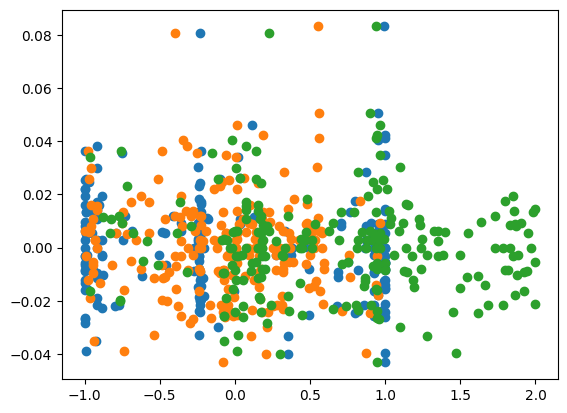

In [162]:
# see at what degree can sentiment linearly explane the returns
from utils import *
import statsmodels.api as sm
plt.scatter(score_history, return_history)
linear = sm.OLS(return_history, score_history).fit()
print(linear.summary())

# Calculate the moving average with a window size of 10
window_size = 3
smoothed = moving_average(score_history, window_size)
linear = sm.OLS(return_history[window_size-1:], smoothed).fit()
plt.scatter(smoothed, return_history[window_size-1:])
print(linear.summary())

# Calculate the exponential of 2 moving average with a window size of 3
alpha = .8
window_size = 2
exp_smoothed = exp_moving(score_history, window_size)
linear = sm.OLS(return_history[window_size-1:], exp_smoothed).fit()
plt.scatter(exp_smoothed, return_history[window_size-1:])
print(linear.summary())

In [125]:
return_history = return_history[window_size-1:]
len(return_history), len(exp_smoothed)

In [164]:
from numpy import std
determinant_senti = score_history
buy = 0
count_buy = 0
count_sell = 0
sell = 0
neutral = 0
state = ""
scores = []
senti_last_day = 0
senti_mean = np.mean(determinant_senti)
senti_std = np.std(determinant_senti)
sell_history = []
buy_history = []
for (senti, returns) in zip(determinant_senti, return_history):
    scores_mean = np.mean(scores)
    if  senti >= (senti_mean + senti_std):
        count_buy += 1
        if state != "buy":
            print('Switch to buy')
            buy += (returns - 0.004)
            state = "buy"
        else:
            buy += returns
    elif senti < (senti_mean - senti_std):
        print('Switch to sell')
        count_sell += 1
        if state != "sell":
            sell += (returns - 0.004)
            state = "sell"
        else:
            sell += returns
    else:
        state = "None"
    senti_last_day = senti
    buy_history.append(buy)
    sell_history.append(sell)
print(f"N positive: {count_buy}; N negative: {count_sell}")
print(f"buy with positive: {buy}")
# print(f"buy with predicted return between +(-)0.004: {neutral}")
print(f"buy with negative: {sell}")
print(f"buy all: {sum(return_history)}")

Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to sell
Swit

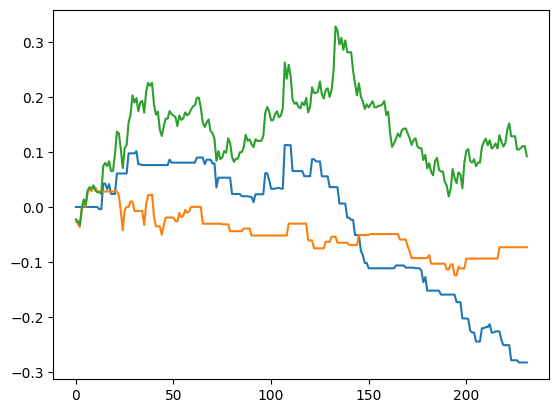

In [165]:
plt.plot(buy_history)
plt.plot(sell_history)
plt.plot(np.cumsum(return_history))

## 3. FINETUNE


##### Procedure


1. Data: tokenised dataloader
2. Train with train data and validate by val data to select epochs and the best model
3. Validate by the test data to check the performance

##### Models


- Finbert
    - Cannot Finetune: The length of tokens over 512. Finetune the model needs padding all input to same length
    - Possible Solution for this
        - Chunk test
- Longformer
    - Finetuning Longformer
    - Finetune by Finbert tokenizer

### 3.1 Dataloader

In [2]:
import pickle
with open("_temp/trainloader.pk", "rb") as f:
    trainloader = pickle.load(f)
with open("_temp/valloader.pk", "rb") as f:
    valloader = pickle.load(f)
with open("_temp/testloader.pk", "rb") as f:
    testloader = pickle.load(f)

"""COLAB
with open("/content/drive/MyDrive/sentiment/_temp/trainloader.pk", "rb") as f:
    trainloader = pickle.load(f)
with open("/content/drive/MyDrive/sentiment/_temp/valloader.pk", "rb") as f:
    valloader = pickle.load(f)
with open("/content/drive/MyDrive/sentiment/_temp/testloader.pk", "rb") as f:
    testloader = pickle.load(f)
"""

EOFError: Ran out of input

### 3.2 Model

In [ ]:
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, \
    TrainingArguments, LongformerConfig, AdamW

# Initialise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "allenai/longformer-base-4096" 
model = LongformerForSequenceClassification.from_pretrained(model_name)
model.to(device)



### 3.3 Finetuning

train on colab

In [ ]:
######################################################
# Train in Colab and dowload longformer_finetuned file
######################################################

# to device
def to_device(input_ids, token_type_ids, attention_mask, returns, device):
    return input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), returns.to(device)

# validate and test
def validate_test(model, dataloader):
    # validation and test
    with torch.no_grad():
        loss = 0
        for (input_ids, token_type_ids, attention_mask, returns) in dataloader:

            # to device
            (input_ids, token_type_ids, attention_mask, returns) = \
                to_device(input_ids, token_type_ids, attention_mask, returns, device)
            
            # set labels
            labels = torch.where(returns > 0, torch.tensor(1), torch.tensor(0))

            # outputs
            outputs = model(input_ids, 
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = labels)
            loss += outputs.loss
        loss /= len(dataloader)
    return outputs, loss

# train
def train(model, epochs, optimizer, trainloader, valloader):
    loss_last_epoch = 100
    loss_train = []
    loss_val = []
    success_epoch = 0
    """
    # check device
    next(model.parameters()).device, input_ids.device
    """
    
    filename = "longformer_finetuned/pretrain"
    model.save_pretrained(filename)
    
    for epoch in range(epochs):
        loss_epoch = 0

        # batch train
        for (input_ids, token_type_ids, attention_mask, returns) in trainloader:
            
            # to device
            (input_ids, token_type_ids, attention_mask, returns) = \
                to_device(input_ids, token_type_ids, attention_mask, returns, device)
            
            # labels
            labels = torch.where(returns > 0, torch.tensor(1), torch.tensor(0))

            # outputs
            outputs = model(input_ids, 
                            token_type_ids=token_type_ids, 
                            attention_mask=attention_mask, 
                            labels = labels)
            
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss

        # train loss for epoch
        loss_epoch = loss_epoch / len(trainloader)
        print(f"loss of epoch {epoch}: {loss_epoch.item()}")

        if loss_epoch < loss_last_epoch:
            success_epoch += 1
            # update loss last epoch
            loss_last_epoch = loss_epoch
            # store model for each epoch
            filename = "longformer_finetuned/epoch{}".format(success_epoch)
            model.save_pretrained(filename)
            # update lr rate
            if optimizer.param_groups[0]['lr'] < 1e-2:
                optimizer.param_groups[0]['lr'] *= 1.2
            # validate
            val_outputs, outputs, val_loss_epoch = validate_test(model, valloader)
            # get loss for all epochs
            loss_train.append(loss_epoch)
            loss_val.append(val_loss_epoch)

        else:
            print("No learning for this epoch")
            # Back to the last epoch model"
            model = LongformerForSequenceClassification.from_pretrained(filename)
            # the model loaded would be cpu
            model.to(device)
            # update lr rate
            optimizer.param_groups[0]['lr'] *= 0.8
            if optimizer.param_groups[0]['lr'] < 1e-5:
                print("End train: learning rate too small")
                break

    return loss_train, loss_val



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-4)

loss_train, loss_val = train(model, epochs, optimizer, trainloader, valloader)
# ----------------------------------
# To get the test outputs
# 1. check the minimum loss epoch
# 2. load the model from the epoch
# 3. outputs, loss = validate_test(model, testloader)

### 3.4 Val Finetuned Models

##### Best model: epoch3 (in colab)
[Error: Error no file named pytorch_model.bin, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory longformer_finetuned/epoch1.](https://github.com/magic-research/magic-animate/issues/12)

In [ ]:
###########################
# This work in colab both CPU and GPU. do not know why don't work here
# Colab code:
"""
for i in range(5):
    filename = "/content/drive/MyDrive/sentiment/longformer_finetuned/epoch{}".format(i + 1)
    print(filename)
    model = LongformerForSequenceClassification.from_pretrained(filename)
    outputs, val_loss = validate_test(model, valloader)
    print(val_loss)
"""
##############################

for i in range(5):
    filename = "longformer_finetuned/epoch{}".format(i + 1)
    print(filename)
    model = LongformerForSequenceClassification.from_pretrained(filename)
    outputs, val_loss = validate_test(model, valloader)
    print(val_loss)


In [ ]:
""" CLOAB
filename = "/content/drive/MyDrive/sentiment/longformer_finetuned/epoch3".format(i + 1)
"""
filename = "/content/drive/MyDrive/sentiment/longformer_finetuned/epoch3"
model = LongformerForSequenceClassification.from_pretrained(filename)
loss = 0

for (input_ids, token_type_ids, attention_mask, returns) in testloader:

    # to device
    (input_ids, token_type_ids, attention_mask, returns) = \
        to_device(input_ids, token_type_ids, attention_mask, returns, device)
    
    # set labels
    labels = torch.where(returns > 0, torch.tensor(1), torch.tensor(0))

    # outputs
    outputs = model(input_ids, 
                    token_type_ids = token_type_ids,
                    attention_mask = attention_mask,
                    labels = labels)
    loss += outputs.loss
loss /= len(dataloader)
loss

### 3.5 Backtest testloader

In [50]:
# backtest functions
def backtest(test_result):

    output, returns, loss = test_result
    labels = {0: "neu", 1:"pos", 2:"neg"}
    positive = 0
    negative = 0
    neutral = 0
    count_positive = 0
    count_negative = 0
    count_neutral = 0
    state = ""
    for (o_, r_) in zip(output, returns):
        if np.argmax(o_.numpy()) == 1:
            count_positive += 1
            positive = positive + (r_ - 0.004) if state != "positive" else positive + r_
            state = "positive"
        elif np.argmax(o_.numpy()) == 2:
            count_negative += 1
            negative = negative + (r_ - 0.004) if state != "negative" else negative + r_
            state = "negative"
        else:
            count_neutral += 1
            neutral = neutral + (r_ - 0.004) if state != "neutral" else neutral + r_
            state = "neutral"
    """
    print(f"N positive: {count_positive}; N neutral: {count_neutral}; N negative: {count_negative}")
    print(f"buy and hold: {returns.sum()}")
    print(f"return of buy when pos: {positive}")
    print(f"return of buy when neu: {neutral}")
    print(f"return of buy when neg: {negative}")
    """
    returns_method = [np.array(returns.sum().reshape(1))[0], np.array(positive).reshape(1)[0],
                      np.array(neutral).reshape(1)[0], np.array(negative).reshape(1)[0]]
    # print(returns_method)
    counts = [count_positive, count_neutral, count_negative]

    return returns_method, counts

# LSTM-FINBERT

### Data

In [ ]:
def get_tokenizers(data_merge):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # get tokenizer for input_ids, token_type_ids, att_masks
    ret_num = torch.tensor(np.array(data_merge["return"])).reshape(-1, 1)
    ret_labels = torch.where(ret_num > 0.005, torch.tensor(1), torch.where(ret_num < -0.005, torch.tensor(2), torch.tensor(0)))
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    tokens = senti_tokenizer(data_merge["shorten_text"].to_list(), return_tensors="pt",
                              max_length=1024,
                              padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

    input_ids = tokens["input_ids"] # 0
    token_type_ids = tokens["token_type_ids"] # 1
    att_masks = tokens["attention_mask"] # 2
    return input_ids, token_type_ids, att_masks, ret_num, ret_labels

def get_dataloader(data_df, returns, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_merge = pd.merge(data_df, returns, on = "time", how = "left")
    input_ids, token_type_ids, att_masks, ret_num, ret_labels = get_tokenizers(data_merge)
    # print(input_ids.shape, ret_num.shape, token_type_ids.shape, att_masks.shape)

    data = TensorDataset(
        input_ids.to(device),
        token_type_ids.to(device),
        att_masks.to(device),
        ret_labels.to(device),
        ret_num.to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# get data from words to tokenized dataloader
path = f"/content/drive/MyDrive/Sentiment/shortened_text/shortened_{media}_{keyword}.pickle"
data_all = pickle_load(path)

# train test split
data_train = data_all[(data_all["time"] >= from_date) & (data_all["time"] <= end_date)]
return_train = returns[(returns["time"] >= from_date) & (returns["time"] <= end_date)]
data_test = data_all[(data_all["time"] >= val_from_date) & (data_all["time"] <= val_end_date)]
return_test = returns[(returns["time"] >= val_from_date) & (returns["time"] <= val_end_date)]
batch_size = 1
data_train = get_dataloader(data_train, returns, batch_size = 5)
data_test = get_dataloader(data_test, returns, batch_size = 1)

### Model

In [ ]:
hidden = (torch.randn(1, 2, 3),
          torch.randn(1, , 3))
hidden[1].shape

torch.Size([1, 1, 3])

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
lstm = nn.LSTM(3, 3)  # 输入维度为3维，输出维度为3维
lstm = nn.LSTM(3, 42, 5, batch_first=True)
inputs = [torch.randn(6, 3) for _ in range(5)]  # 生成一个长度为5的序列

# 初始化隐藏状态.
hidden = (torch.randn(5, 1, 42),
          torch.randn(5, 1, 42))
for i in inputs:
    # 将序列中的元素逐个输入到LSTM.
    # 经过每步操作,hidden 的值包含了隐藏状态的信息.
    print(i.view(1, i.shape[0], i.shape[1]).shape)
    out, hidden = lstm(i.view(1, i.shape[0], i.shape[1]), hidden)
    print(out.shape)
    print(hidden[0].shape)
    break

torch.Size([1, 6, 3])
torch.Size([1, 6, 42])
torch.Size([5, 1, 42])


In [ ]:
gc.collect()

4179

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        out, _ = self.lstm(x[0].view(1, x[0].shape[0], x[0].shape[1]), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)

input_size = 3
hidden_size = 6
num_layers = 3
output_size = 1
model = lstm(senti_finbert, input_size, hidden_size, num_layers, output_size)
for i, batch in enumerate(data_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = batch[0].to(device)
    token_type_ids = batch[1].to(device)
    attention_mask = batch[2].to(device)
    ret_labels = batch[3].to(device)
    ret_num = batch[4].to(device)
    out = model(input_ids, token_type_ids, attention_mask)
    print(out)
    break

In [ ]:
a[0]

tensor([[ 5.0697, -4.7721, -2.7422],
        [ 0.8556,  0.1799, -4.1545],
        [ 0.1794, -3.2106,  4.0470],
        [-2.0179, -3.3628,  5.3450],
        [ 6.5229, -4.9477, -3.7289]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, x):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size =  input_dimension  # Size of input features
hidden_size = lstm_hidden_size  # Number of LSTM units (hidden states)
num_layers = lstm_num_layers   # Number of LSTM layers
output_size = num_classes      # Number of classes for classification

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:  # Iterate through your dataset
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
This is a basic outline of how to create an LSTM model using PyTorch's torch.nn.LSTM module. Remember to replace placeholders like input_dimension, lstm_hidden_size, lstm_num_layers, num_classes, learning_rate, and implement your own data loading pipeline using dataloader.







SyntaxError: ignored

In [ ]:
output, returns = backtest_finbert(data_test, finetune = True)
def backtesting(data_test, FT_senti_finbert, type_): # type: [finetune, add_layer]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 3)) if type_ == "finetune" else  torch.empty((0, 1))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        if type_ == "finetune":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = ret_labels.long())
            output = output[1]
        if type_ == "add_layer":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask)
        output_test = torch.cat((output_test, output.detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    return output_test, returns_test, loss_sum/(index + 1)

In [ ]:
#### Not shorten func (newest)
def get_tokenizers(data_df, returns, device):
    # get tokenizer for input_ids, token_type_ids, att_masks
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    input_ids = []
    token_type_ids = []
    att_masks = []
    labels = []
    returns_num = []
    crossdate_text = ""
    state = "continuous"
    for index, i in data_df.reset_index().iterrows():
        print(i[1])
        tokens = senti_tokenizer(i[3], return_tensors="pt",
                                 max_length=max([len(l) for l in data_df["text"]]),
                                 padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

        input_ids.append(tokens["input_ids"]) # 0
        token_type_ids.append(tokens["token_type_ids"]) # 1
        att_masks.append(tokens["attention_mask"]) # 2
        if returns["return"][returns["time"] == i[1]].values >= 0.005: # pos
            returns_label = torch.tensor(1)
        elif returns["return"][returns["time"] == i[1]].values <= -0.005: # neg
            returns_label = torch.tensor(2)
        else: # neu
            returns_label = torch.tensor(0)
        labels.append(returns_label)
        returns_num.append(torch.tensor(returns["return"][returns["time"] == i[1]].values))
    return input_ids, token_type_ids, att_masks, labels, returns_num

def get_dataloader(data_df, returns, from_date, end_date, path, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_df = data_df[(data_df["time"] >= from_date) & (data_df['time'] <= end_date)]
    input_ids, token_type_ids, att_masks, labels, returns_num = get_tokenizers(data_df, returns, device)
    max_inputs = max([i.shape[1] for i in input_ids])
    max_tokens = max([i.shape[1] for i in token_type_ids])
    max_atts = max([i.shape[1] for i in att_masks])
    input_ids = [torch.nn.functional.pad(i, (0,max_inputs - i.shape[1])) for i in input_ids]
    token_type_ids = [torch.nn.functional.pad(i, (0, max_tokens - i.shape[1])) for i in token_type_ids]
    att_masks = [torch.nn.functional.pad(i, (0, max_atts - i.shape[1])) for i in att_masks]
    # print(torch.stack(input_ids).squeeze(1).to(device), token_type_ids, att_masks)

    data = TensorDataset(
        torch.stack(input_ids).squeeze(1).to(device),
        torch.stack(token_type_ids).squeeze(1).to(device),
        torch.stack(att_masks).squeeze(1).to(device),
        torch.stack(labels).to(device),
        torch.stack(returns_num).to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# from Eng to tokens
# seperate whole tokens by 512, the limit of transformers, and add the result together for each part
# compute loss with labels, eg: tensor([1]), tensor([[ 6.0247, -8.2679, -4.6360]], grad_fn=<AddBackward0>)
# confirm working and training ok. while sometimes it won't train don't know why. maybe is lr??? to figure out
class Net(torch.nn.Module):

    def __init__(self, in_size): # input_ids.shape[1]# , hd_size
        super(Net, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.linear_tobert = torch.nn.Linear(in_size, 512).to(device)
        self.activation = torch.nn.functional.relu
        self.norm1 = torch.nn.BatchNorm1d(in_size).to(device)

    def forward(self, input_ids, token_type_ids, attention_masks, labels):
        # positional encoding?
        scores =  torch.zeros([input_ids.shape[0], 3], dtype = torch.float32).to(device)
        for k, i in enumerate(range(input_ids.shape[1]//512)):
            part_input_ids = input_ids[:, i*512:(i+1)*512]
            part_token_type_ids = token_type_ids[:, i*512:(i+1)*512]
            part_att_masks = attention_masks[:, i*512:(i+1)*512]
            # print(part_input_ids, part_token_type_ids, part_att_masks)
            x = senti_finbert(part_input_ids,
                              token_type_ids = part_token_type_ids,
                              attention_mask = part_att_masks)
            scores += x[0]
            if k >= 2:
                break
        return scores

In [ ]:
# working codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epoch"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    loss = 0
    for index, batch in enumerate(data):
        gc.collect()
        for i in range(input_ids.shape[1]//512)
        input_ids = torch.tensor(batch[0][:, :512]).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(batch[1][:, :512]).to(device)
        att_masks = torch.tensor(batch[2][:, :512]).to(device)
        labels = torch.tensor(batch[3]).to(device)
        returns_num = batch[4].to(device)
        output = senti_finbert(input_ids,
                                     token_type_ids = token_type_ids,
                                     attention_mask = att_masks,
                                     labels = labels.long())
        print(labels, output)
        loss = output[0]
        loss.backward()
        # clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        loss += loss
    print(loss)


"""
        input_ids = torch.tensor(self.linear_tobert(torch.tensor(input_ids, dtype = torch.float32)), dtype =  torch.int).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(self.linear_tobert(torch.tensor(token_type_ids, dtype = torch.float32)), dtype =  torch.int).to(device)
        attention_mask = torch.tensor(self.linear_tobert(torch.tensor(attention_mask, dtype = torch.float32)), dtype =  torch.int).to(device)
"""

In [ ]:
config = {
    "epcoh": 10,
    "lr": 1,
    "weight_d": 0.00,
    "num_warmstep": 5000, # 10000
          }
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epcoh"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    for index, batch in enumerate(data):
        b_input_id = batch[0][:, :512].to(device)
        b_token_type_id = batch[1][:, :512].to(device)
        b_att_mask = batch[2][:, :512].to(device)
        b_labels = batch[3].to(device)
        # senti_finbert.zero_grad()
        output = senti_finbert(input_ids = b_input_id, token_type_ids = b_token_type_id, attention_mask = b_att_mask, labels = b_labels)
        loss, logits = output[0], output[1]
        loss.backward()
        clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        print(logits)
        #print(b_input_id.shape)
        #print(b_token_type_id.shape)
        #print(b_att_mask.shape)
        #print(b_labels.shape)

"""
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
"""

tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)
tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: ignored